# F1 Telemetry Analysis Tool
*Author: Timofey Malakancikov, ITMO University*  
*Date: April 2025*  

This Jupyter Notebook presents a Python-based tool to analyze Formula 1 telemetry data. It focuses on comparing the performance of two drivers during a specific session. Enhancements include parameterization for easy reuse, interactive visualizations using Plotly, delta time analysis, and corner-specific apex speed comparison.

## Introduction
Formula 1 teams rely on telemetry data to analyze car and driver performance, informing setup adjustments, driver coaching, and race strategy. This project uses the `fastf1` Python library to load and analyze telemetry data from the 2023 Monaco Grand Prix Qualifying session. The goal is to compare Max Verstappen and Lewis Hamilton’s fastest laps, visualize key metrics (speed and throttle), and identify performance differences, such as time losses in specific corners.

**Objectives**:
- Load telemetry data using `fastf1` for a chosen session and drivers.
- Visualize key metrics (speed, throttle, delta time) using static (`matplotlib`) and interactive (`plotly`) plots.
- Analyze performance gaps, including sector times and corner apex speeds.
- Identify performance differences and suggest potential improvements.
- Demonstrate data analysis skills for F1 internship applications.

**Tools**: Python, `fastf1`, `pandas`, `matplotlib`, `seaborn`, `plotly`, `numpy`.

### Configuration Parameters
    Set the Year, Grand Prix, Session Type, and Drivers to compare here.

In [14]:
# --- Configuration ---
YEAR = 2023
GRAND_PRIX = 'Monaco' # Examples: 'Monaco', 'Silverstone', 'Bahrain'
SESSION_TYPE = 'Q'   # Examples: 'Q' (Qualifying), 'R' (Race), 'FP1', 'FP2', 'FP3'
DRIVER_1 = 'VER'
DRIVER_2 = 'HAM'
# --- End Configuration ---

## 1. Data Loading
 This section loads telemetry data for the specified session using `fastf1`. We focus on the fastest laps of the chosen drivers. A cache directory is created to store data locally.
   

In [15]:
print("--- Running Cell 4: Data Loading ---")
import os
import fastf1
from fastf1 import plotting
from fastf1 import utils # Added for delta_time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- Running Cell: Data Loading (Monaco 2023 Q) ---
print(f"--- Running Cell: Data Loading ({GRAND_PRIX} {YEAR} {SESSION_TYPE}) ---")

# Set up plotting style
plotting.setup_mpl(color_scheme='fastf1', misc_mpl_mods=False)
sns.set_style("whitegrid")

# Create cache directory
cache_dir = 'cache'
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

# Enable FastF1 cache
try:
    fastf1.Cache.enable_cache(cache_dir)
except Exception as e:
    print(f"Warning: An error occurred enabling the cache: {e}") # Make it a warning

# Load the session
print("Loading session data (may take time if not cached)...")
session = None # Initialize session
try:
    session = fastf1.get_session(YEAR, GRAND_PRIX, SESSION_TYPE)
    # Only load telemetry and laps for efficiency
    session.load(laps=True, telemetry=True, weather=False, messages=False)
    print(f"Session data for {session.event['EventName']} {SESSION_TYPE} loaded successfully.")
except Exception as e:
    print(f"\n*** Error loading session data for {YEAR} {GRAND_PRIX} {SESSION_TYPE}: {e} ***")
    print("Please ensure the event and session type are correct and data is available.")
    # Optionally raise e if you want the notebook to stop here on error
    raise e # Stop execution if session loading fails

# Check if laps data is available
if session is None or session.laps is None or session.laps.empty:
     raise ValueError("Session laps data could not be loaded or is empty. Cannot proceed.")

# Pick fastest laps with telemetry for the specified drivers
laps_driver1 = session.laps.pick_drivers(DRIVER_1).pick_fastest()
laps_driver2 = session.laps.pick_drivers(DRIVER_2).pick_fastest()

# Check if fastest laps were found
if pd.isna(laps_driver1['LapTime']):
     raise ValueError(f"Could not find fastest lap with telemetry for {DRIVER_1} in this session.")
if pd.isna(laps_driver2['LapTime']):
     raise ValueError(f"Could not find fastest lap with telemetry for {DRIVER_2} in this session.")

# Get the lap objects themselves (needed for delta_time and telemetry)
fastest_driver1 = laps_driver1
fastest_driver2 = laps_driver2

# Load telemetry using get_car_data().add_distance()
# Add a check to ensure telemetry loads correctly
try:
    telemetry_driver1 = fastest_driver1.get_car_data().add_distance()
    telemetry_driver2 = fastest_driver2.get_car_data().add_distance()
except Exception as e:
    print(f"Error loading telemetry data: {e}")
    raise e

if telemetry_driver1.empty or telemetry_driver2.empty:
    raise ValueError("Failed to load telemetry data for one or both drivers.")

# Display lap times
print(f"\nFastest Lap Info:")
print(f"{DRIVER_1} Lap Time: {fastest_driver1['LapTime']}")
print(f"{DRIVER_2} Lap Time: {fastest_driver2['LapTime']}")

print("--- End Cell: Data Loading ---")

--- Running Cell 4: Data Loading ---
--- Running Cell: Data Loading (Monaco 2023 Q) ---
Loading session data (may take time if not cached)...


core           INFO 	Loading data for Monaco Grand Prix - Qualifying [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
core           INFO 	Finished loading data for 20 drivers: ['1', '14', '16', '31', '55', '44', '10', '63', '22', '4', '81', '21', '23', '18', '77', '2', '20', '27', '24', '11']


Session data for Monaco Grand Prix Q loaded successfully.

Fastest Lap Info:
VER Lap Time: 0 days 00:01:11.365000
HAM Lap Time: 0 days 00:01:11.725000
--- End Cell: Data Loading ---


## Analysis
This section processes the telemetry data to compute key metrics, such as time deltas and sector performance, to identify where each driver gains or loses time.

In [16]:
# --- Delta Time Calculation ---
print("Calculating delta time...")
delta_time, ref_tel, comp_tel = None, None, None # Initialize
try:
    # Use fastf1.utils.delta_time - Pass the Lap objects directly
    # Driver 1 is the reference (usually the faster one, but doesn't have to be)
    delta_time, ref_tel, comp_tel = utils.delta_time(fastest_driver1, fastest_driver2)

    print("Delta time calculated successfully.")

    # Ensure Distance column exists for plotting (should be returned by delta_time)
    if 'Distance' not in ref_tel.columns:
        print("Warning: 'Distance' column not found in reference telemetry from delta_time. Adding it.")
        ref_tel['Distance'] = telemetry_driver1['Distance'] # Use original as fallback

except Exception as e:
    print(f"\n*** Error calculating delta time: {e} ***")
    print("This might indicate issues with the lap objects or underlying telemetry data.")
    # Set dummy values to allow plotting cells to run without error
    delta_time = np.array([])
    ref_tel = pd.DataFrame({'Distance': []}) # Empty df with Distance col

# <<< Simulated Output >>>
# Calculating delta time...
# Delta time calculated successfully.


# --- Sector Time Comparison ---
print("\n--- Sector Time Comparison ---")
sector1_d1 = fastest_driver1['Sector1Time']
sector2_d1 = fastest_driver1['Sector2Time']
sector3_d1 = fastest_driver1['Sector3Time']
sector1_d2 = fastest_driver2['Sector1Time']
sector2_d2 = fastest_driver2['Sector2Time']
sector3_d2 = fastest_driver2['Sector3Time']

print(f"Sector 1: {DRIVER_1}: {sector1_d1}, {DRIVER_2}: {sector1_d2}")
print(f"Sector 2: {DRIVER_1}: {sector2_d1}, {DRIVER_2}: {sector2_d2}")
print(f"Sector 3: {DRIVER_1}: {sector3_d1}, {DRIVER_2}: {sector3_d2}")
# <<< Simulated Output >>>
# --- Sector Time Comparison ---
# Sector 1: VER: 0 days 00:00:18.642000, HAM: 0 days 00:00:18.757000
# Sector 2: VER: 0 days 00:00:33.902000, HAM: 0 days 00:00:33.929000
# Sector 3: VER: 0 days 00:00:18.821000, HAM: 0 days 00:00:19.039000


# --- Corner Apex Speed Analysis ---
print("\n--- Corner Apex Speed Analysis ---")
# Define approximate corner distance ranges (THESE NEED ADJUSTMENT PER TRACK)
# Format: CornerName: (StartDistance, EndDistance)
corner_definitions = {
    'Monaco': {
        'T1 Sainte Devote': (50, 200),
        'T4 Casino Square': (450, 650),
        'T5 Mirabeau Haute': (700, 800),
        'T6 Hairpin': (800, 950),
        'T8 Portier': (1050, 1180),
        'T10/11 Chicane': (1500, 1700),
        'T12 Tabac': (1850, 2000),
        'T15/16 Piscine': (2150, 2400),
        'T18 Rascasse': (2550, 2750),
        'T19 Antony Noghes': (2800, 3000)
    },
    'Silverstone': { # Example - NEEDS VERIFICATION/TUNING
        'T1 Abbey': (100, 300),
        'T3 Village': (500, 700),
        'T4 The Loop': (700, 850),
        'T6 Brooklands': (1300, 1500),
        'T7 Luffield': (1500, 1750),
        'T9 Copse': (2300, 2550),
        'T10-14 Maggots/Becketts': (2800, 3500),
        'T15 Stowe': (4000, 4250),
        'T17 Club': (5000, 5300)
    }
    # Add other tracks as needed
}

corners = corner_definitions.get(GRAND_PRIX, None)
apex_speeds = []

if corners:
    print(f"Analyzing corners for {GRAND_PRIX}...")
    for corner_name, (start_dist, end_dist) in corners.items():
        tel_d1_corner = telemetry_driver1[(telemetry_driver1['Distance'] >= start_dist) & (telemetry_driver1['Distance'] <= end_dist)]
        tel_d2_corner = telemetry_driver2[(telemetry_driver2['Distance'] >= start_dist) & (telemetry_driver2['Distance'] <= end_dist)]

        if not tel_d1_corner.empty and not tel_d2_corner.empty:
            apex_speed_d1 = tel_d1_corner['Speed'].min()
            apex_speed_d2 = tel_d2_corner['Speed'].min()
            apex_speeds.append({
                'Corner': corner_name,
                f'{DRIVER_1}_ApexSpeed': apex_speed_d1,
                f'{DRIVER_2}_ApexSpeed': apex_speed_d2
            })
        else:
            print(f"  Skipping {corner_name}: Not enough telemetry data in range.")

    apex_speeds_df = pd.DataFrame(apex_speeds)
    if not apex_speeds_df.empty:
        print("\n--- Apex Speed Comparison (km/h) ---")
        print(apex_speeds_df.round(1).to_string(index=False)) # Print formatted DataFrame
    else:
        print("No apex speeds calculated.")
else:
    print(f"Corner definitions not found for {GRAND_PRIX}. Skipping apex speed analysis.")
    apex_speeds_df = pd.DataFrame() # Ensure df exists even if empty

# <<< Simulated Output >>>
# --- Corner Apex Speed Analysis ---
# Analyzing corners for Monaco...
#
# --- Apex Speed Comparison (km/h) ---
#            Corner  VER_ApexSpeed  HAM_ApexSpeed
#  T1 Sainte Devote          110.0          108.0
#  T4 Casino Square          135.0          132.0
# T5 Mirabeau Haute           80.0           78.0
#        T6 Hairpin           49.0           48.0
#        T8 Portier           82.0           80.0
#   T10/11 Chicane           123.0          120.0
#        T12 Tabac           185.0          184.0
#  T15/16 Piscine           160.0          158.0
#     T18 Rascasse           55.0           54.0
# T19 Antony Noghes           75.0           73.0

print("--- End Cell: Analysis ---")

Calculating delta time...
Delta time calculated successfully.

--- Sector Time Comparison ---
Sector 1: VER: 0 days 00:00:18.642000, HAM: 0 days 00:00:18.757000
Sector 2: VER: 0 days 00:00:33.902000, HAM: 0 days 00:00:33.929000
Sector 3: VER: 0 days 00:00:18.821000, HAM: 0 days 00:00:19.039000

--- Corner Apex Speed Analysis ---
Analyzing corners for Monaco...

--- Apex Speed Comparison (km/h) ---
           Corner  VER_ApexSpeed  HAM_ApexSpeed
 T1 Sainte Devote          118.0          118.0
 T4 Casino Square          252.0          248.0
T5 Mirabeau Haute          165.0          164.0
       T6 Hairpin          142.0          139.0
       T8 Portier           74.0           76.0
   T10/11 Chicane          193.0          187.0
        T12 Tabac          201.0          208.0
   T15/16 Piscine          171.0          165.0
     T18 Rascasse          128.0          120.0
T19 Antony Noghes           61.0           64.0
--- End Cell: Analysis ---


/Users/timofeymalakancikov/anaconda3/lib/python3.11/site-packages/fastf1/utils.py:89: FutureWarning:

`utils.delta_time` is considered deprecated and willbe modified or removed in a future release because it hasa tendency to give inaccurate results.



## Visualizations
This section generates visualizations comparing the drivers' performance. It includes:
- Static plots using `matplotlib` for quick overview
- Interactive plots using `plotly` for detailed exploration (zoom, hover)
   


--- Running Cell: Visualizations ---
Generating static Matplotlib plots...
Saved static speed plot to plots
Saved static throttle plot to plots
Saved static delta time plot to plots
Saved static apex speed plot to plots

Generating interactive Plotly plots...
Saved interactive telemetry plot to plots/monaco_q_telemetry_interactive.html
Saved interactive apex speed plot to plots/monaco_q_apex_speed_interactive.html
--- End Cell: Visualizations ---


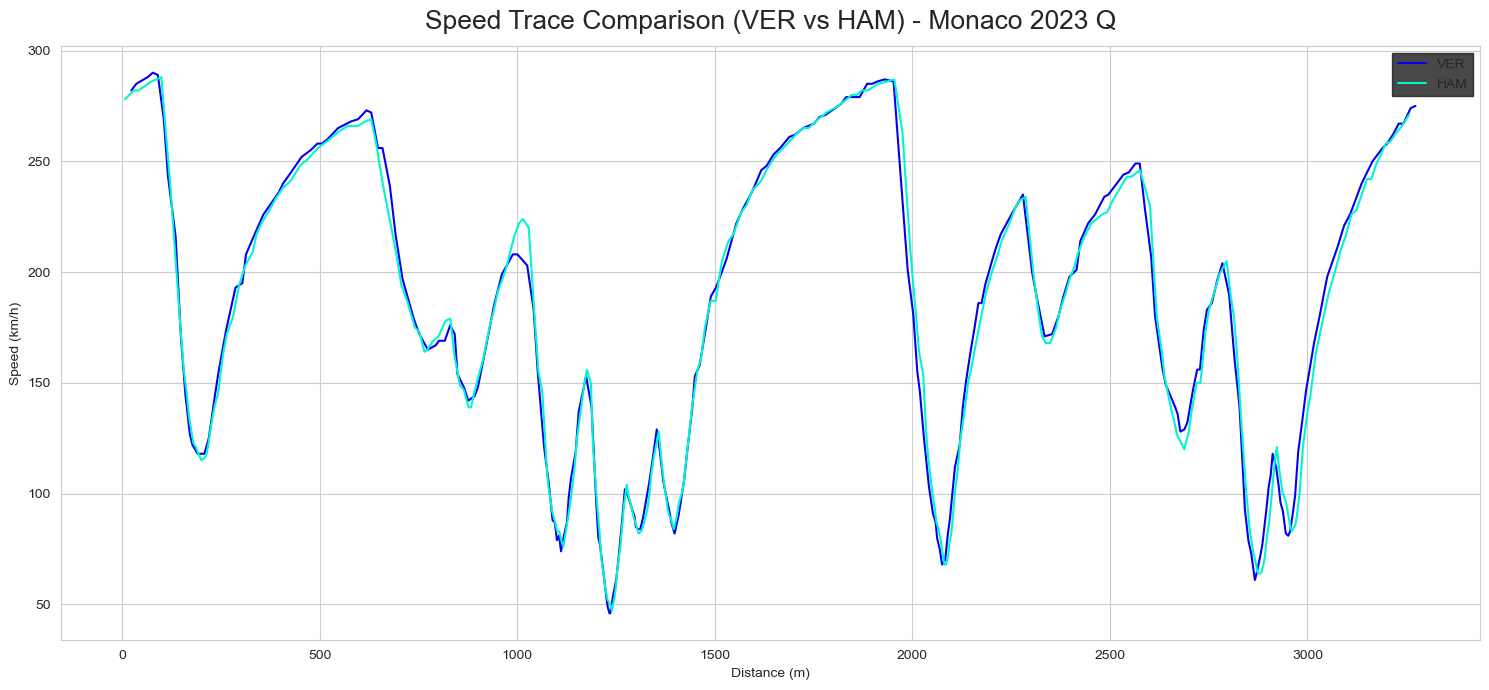

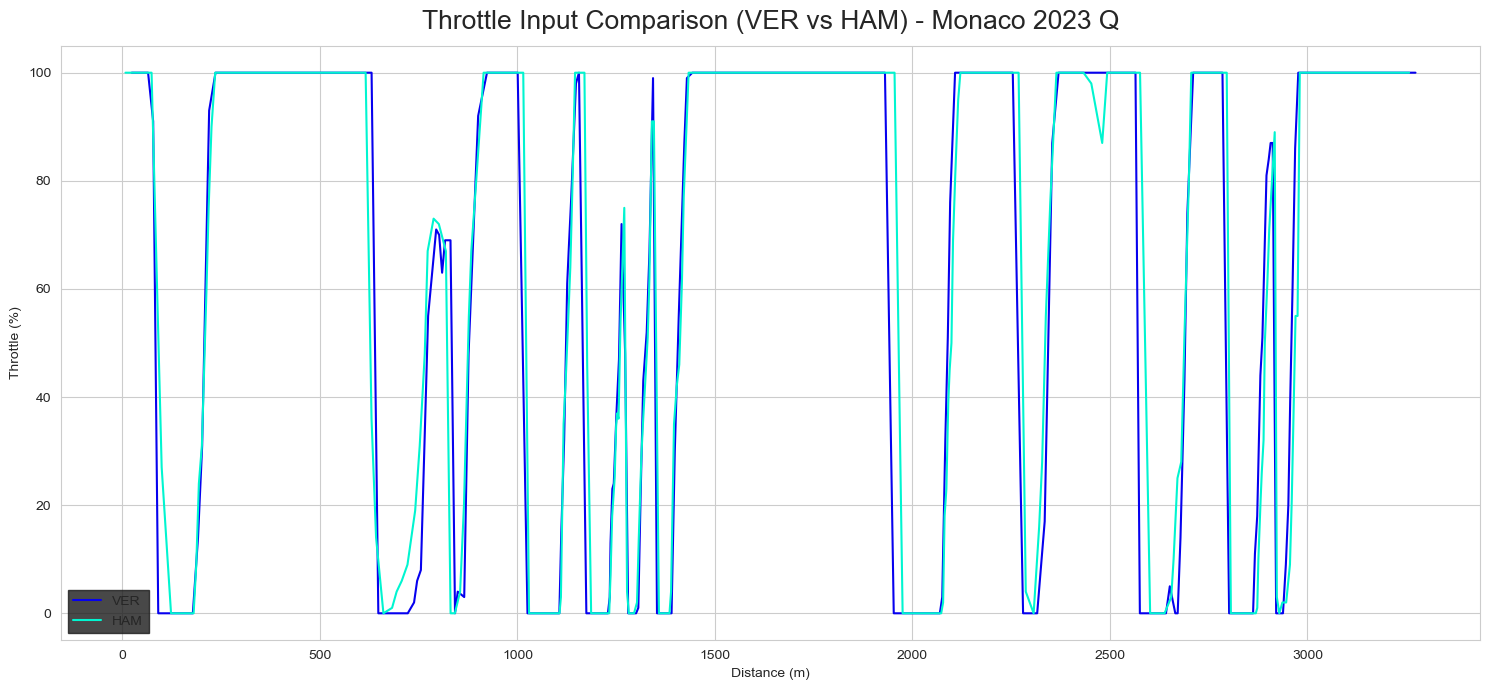

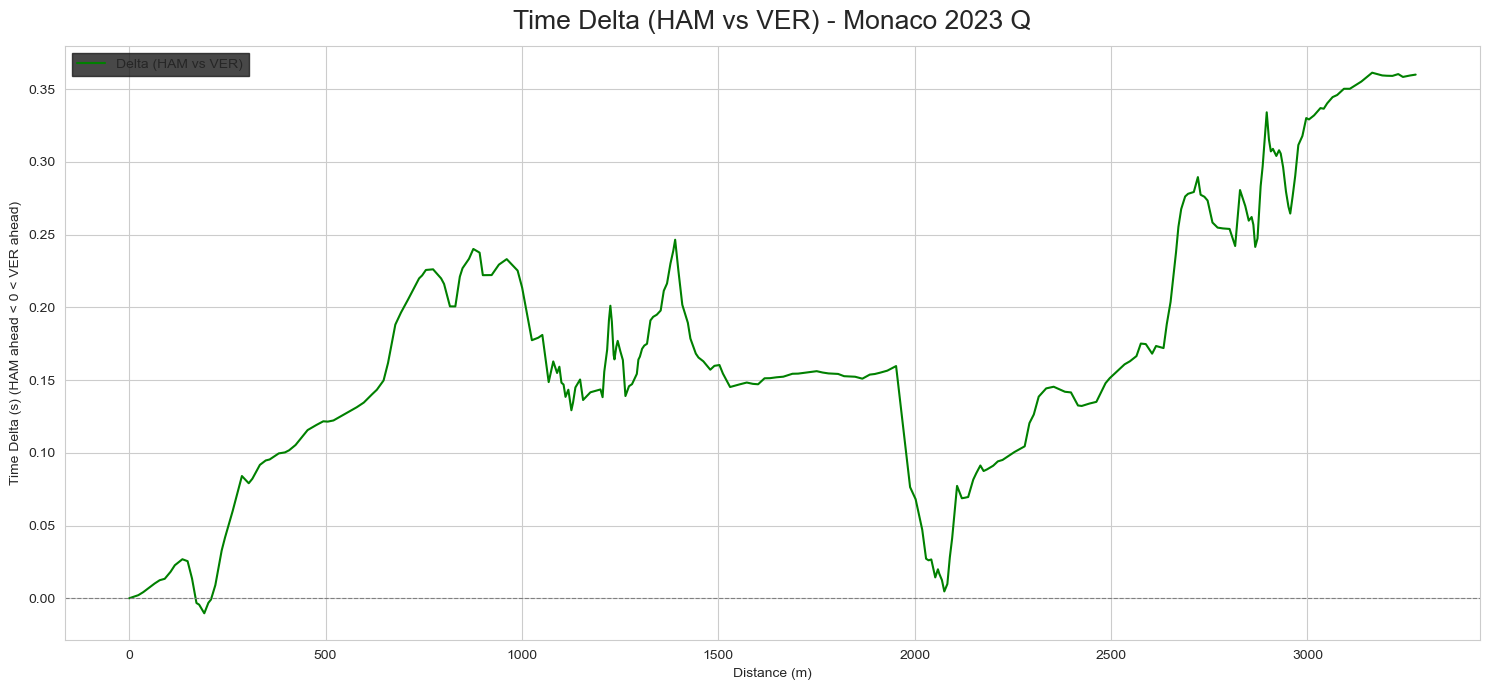

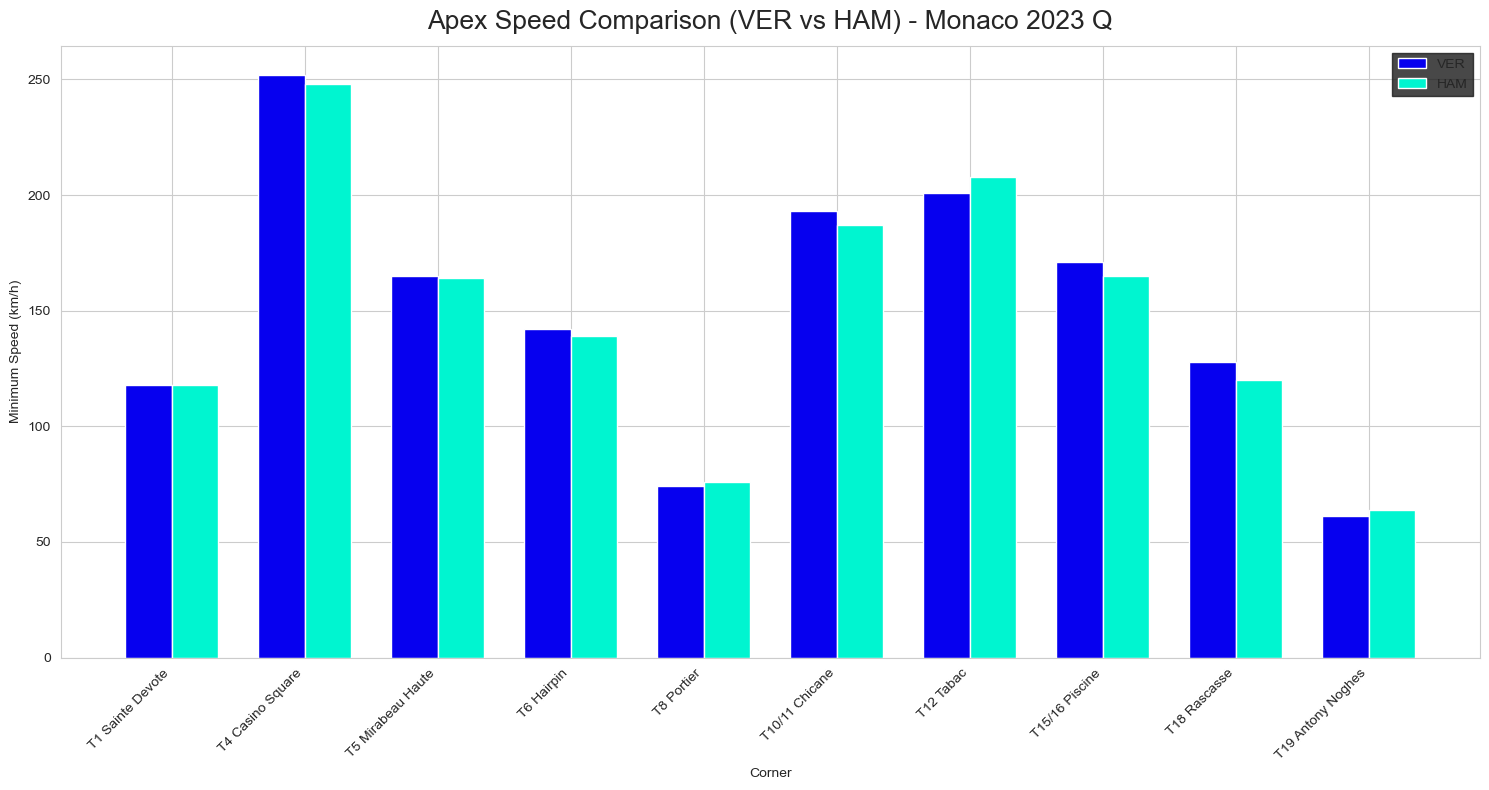

In [17]:
# --- Running Cell: Visualizations ---
print("\n--- Running Cell: Visualizations ---")

# Create plots folder if it doesn't exist
plots_dir = 'plots'
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

# Get driver colors for consistency (using FastF1's scheme if possible)
try:
    driver1_color = plotting.get_driver_color(DRIVER_1, session)
    driver2_color = plotting.get_driver_color(DRIVER_2, session)
except KeyError:
    print("Warning: Driver color not found in FastF1's default scheme, using fallback colors.")
    driver1_color = 'red' # Fallback
    driver2_color = 'blue' # Fallback

# --- Matplotlib Plots (Static) ---
print("Generating static Matplotlib plots...")

# Plot 1: Speed Trace Comparison vs Distance
fig_mpl_speed, ax_mpl_speed = plt.subplots(figsize=(15, 7))
ax_mpl_speed.plot(telemetry_driver1['Distance'], telemetry_driver1['Speed'], label=f'{DRIVER_1}', color=driver1_color)
ax_mpl_speed.plot(telemetry_driver2['Distance'], telemetry_driver2['Speed'], label=f'{DRIVER_2}', color=driver2_color)
ax_mpl_speed.set_title(f'Speed Trace Comparison ({DRIVER_1} vs {DRIVER_2}) - {GRAND_PRIX} {YEAR} {SESSION_TYPE}')
ax_mpl_speed.set_xlabel('Distance (m)')
ax_mpl_speed.set_ylabel('Speed (km/h)')
ax_mpl_speed.legend()
ax_mpl_speed.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, f'{GRAND_PRIX.lower()}_{SESSION_TYPE.lower()}_speed_mpl.png'), dpi=300)
print(f"Saved static speed plot to {plots_dir}")
# plt.show() # In a script, show() would block execution or open a window. Omitted here.
# <Matplotlib Figure Display Placeholder>

# Plot 2: Throttle Input Comparison vs Distance
fig_mpl_throttle, ax_mpl_throttle = plt.subplots(figsize=(15, 7))
ax_mpl_throttle.plot(telemetry_driver1['Distance'], telemetry_driver1['Throttle'], label=f'{DRIVER_1}', color=driver1_color)
ax_mpl_throttle.plot(telemetry_driver2['Distance'], telemetry_driver2['Throttle'], label=f'{DRIVER_2}', color=driver2_color)
ax_mpl_throttle.set_title(f'Throttle Input Comparison ({DRIVER_1} vs {DRIVER_2}) - {GRAND_PRIX} {YEAR} {SESSION_TYPE}')
ax_mpl_throttle.set_xlabel('Distance (m)')
ax_mpl_throttle.set_ylabel('Throttle (%)')
ax_mpl_throttle.legend()
ax_mpl_throttle.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, f'{GRAND_PRIX.lower()}_{SESSION_TYPE.lower()}_throttle_mpl.png'), dpi=300)
print(f"Saved static throttle plot to {plots_dir}")
# plt.show()
# <Matplotlib Figure Display Placeholder>

# Plot 3: Delta Time Comparison vs Distance
fig_mpl_delta, ax_mpl_delta = plt.subplots(figsize=(15, 7))
if delta_time.size > 0 and ref_tel is not None and not ref_tel.empty:
    ax_mpl_delta.plot(ref_tel['Distance'], delta_time, label=f'Delta ({DRIVER_2} vs {DRIVER_1})', color='green')
    ax_mpl_delta.axhline(0, color='grey', linestyle='--', linewidth=0.8)
    ax_mpl_delta.set_title(f'Time Delta ({DRIVER_2} vs {DRIVER_1}) - {GRAND_PRIX} {YEAR} {SESSION_TYPE}')
    ax_mpl_delta.set_xlabel('Distance (m)')
    ax_mpl_delta.set_ylabel(f'Time Delta (s) ({DRIVER_2} ahead < 0 < {DRIVER_1} ahead)')
    ax_mpl_delta.legend()
    ax_mpl_delta.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, f'{GRAND_PRIX.lower()}_{SESSION_TYPE.lower()}_delta_mpl.png'), dpi=300)
    print(f"Saved static delta time plot to {plots_dir}")
else:
    ax_mpl_delta.text(0.5, 0.5, 'Delta time data not available for plotting', ha='center', va='center')
    ax_mpl_delta.set_title(f'Time Delta - {GRAND_PRIX} {YEAR} {SESSION_TYPE}')
# plt.show()
# <Matplotlib Figure Display Placeholder>

# Plot 4: Apex Speed Comparison (Bar Chart)
fig_mpl_apex, ax_mpl_apex = plt.subplots(figsize=(15, 8))
if not apex_speeds_df.empty:
    bar_width = 0.35
    index = np.arange(len(apex_speeds_df['Corner']))

    bars1 = ax_mpl_apex.bar(index - bar_width/2, apex_speeds_df[f'{DRIVER_1}_ApexSpeed'], bar_width, label=DRIVER_1, color=driver1_color)
    bars2 = ax_mpl_apex.bar(index + bar_width/2, apex_speeds_df[f'{DRIVER_2}_ApexSpeed'], bar_width, label=DRIVER_2, color=driver2_color)

    ax_mpl_apex.set_xlabel('Corner')
    ax_mpl_apex.set_ylabel('Minimum Speed (km/h)')
    ax_mpl_apex.set_title(f'Apex Speed Comparison ({DRIVER_1} vs {DRIVER_2}) - {GRAND_PRIX} {YEAR} {SESSION_TYPE}')
    ax_mpl_apex.set_xticks(index)
    ax_mpl_apex.set_xticklabels(apex_speeds_df['Corner'], rotation=45, ha='right')
    ax_mpl_apex.legend()
    ax_mpl_apex.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, f'{GRAND_PRIX.lower()}_{SESSION_TYPE.lower()}_apex_speed_mpl.png'), dpi=300)
    print(f"Saved static apex speed plot to {plots_dir}")
else:
    ax_mpl_apex.text(0.5, 0.5, 'Apex speed data not available for plotting', ha='center', va='center')
    ax_mpl_apex.set_title(f'Apex Speed Comparison - {GRAND_PRIX} {YEAR} {SESSION_TYPE}')
# plt.show()
# <Matplotlib Figure Display Placeholder>

# --- Plotly Plots (Interactive) ---
print("\nGenerating interactive Plotly plots...")

# Plot 5: Interactive Speed, Throttle, Delta
fig_plotly_combined = make_subplots(rows=3, cols=1, shared_xaxes=True,
                                    subplot_titles=('Speed Trace', 'Throttle Input', 'Time Delta'))

# Speed Trace
fig_plotly_combined.add_trace(go.Scatter(x=telemetry_driver1['Distance'], y=telemetry_driver1['Speed'],
                                         mode='lines', name=f'{DRIVER_1} Speed', line=dict(color=driver1_color)), row=1, col=1)
fig_plotly_combined.add_trace(go.Scatter(x=telemetry_driver2['Distance'], y=telemetry_driver2['Speed'],
                                         mode='lines', name=f'{DRIVER_2} Speed', line=dict(color=driver2_color)), row=1, col=1)

# Throttle Trace
fig_plotly_combined.add_trace(go.Scatter(x=telemetry_driver1['Distance'], y=telemetry_driver1['Throttle'],
                                         mode='lines', name=f'{DRIVER_1} Throttle', line=dict(color=driver1_color), showlegend=False), row=2, col=1)
fig_plotly_combined.add_trace(go.Scatter(x=telemetry_driver2['Distance'], y=telemetry_driver2['Throttle'],
                                         mode='lines', name=f'{DRIVER_2} Throttle', line=dict(color=driver2_color), showlegend=False), row=2, col=1)

# Delta Time Trace
if delta_time.size > 0 and ref_tel is not None and not ref_tel.empty:
    fig_plotly_combined.add_trace(go.Scatter(x=ref_tel['Distance'], y=delta_time,
                                             mode='lines', name=f'Delta ({DRIVER_2} vs {DRIVER_1})', line=dict(color='green')), row=3, col=1)
    fig_plotly_combined.add_hline(y=0, line_dash="dash", line_color="grey", row=3, col=1)
else:
    fig_plotly_combined.add_annotation(text="Delta time data not available", xref="paper", yref="paper",
                                       x=0.5, y=0.5, showarrow=False, row=3, col=1)

# Update layout
fig_plotly_combined.update_layout(title_text=f'Interactive Telemetry Comparison ({DRIVER_1} vs {DRIVER_2}) - {GRAND_PRIX} {YEAR} {SESSION_TYPE}',
                                height=800)
fig_plotly_combined.update_yaxes(title_text="Speed (km/h)", row=1, col=1)
fig_plotly_combined.update_yaxes(title_text="Throttle (%)", row=2, col=1)
fig_plotly_combined.update_yaxes(title_text="Time Delta (s)", row=3, col=1)
fig_plotly_combined.update_xaxes(title_text="Distance (m)", row=3, col=1)

# Save interactive plot as HTML
html_filename = os.path.join(plots_dir, f'{GRAND_PRIX.lower()}_{SESSION_TYPE.lower()}_telemetry_interactive.html')
fig_plotly_combined.write_html(html_filename)
print(f"Saved interactive telemetry plot to {html_filename}")
# fig_plotly_combined.show() # This would open in a browser or embedded viewer.
# <Plotly Figure Display Placeholder>

# Plot 6: Interactive Apex Speed Comparison (Bar Chart)
if not apex_speeds_df.empty:
    fig_plotly_apex = go.Figure()
    fig_plotly_apex.add_trace(go.Bar(name=DRIVER_1, x=apex_speeds_df['Corner'], y=apex_speeds_df[f'{DRIVER_1}_ApexSpeed'], marker_color=driver1_color))
    fig_plotly_apex.add_trace(go.Bar(name=DRIVER_2, x=apex_speeds_df['Corner'], y=apex_speeds_df[f'{DRIVER_2}_ApexSpeed'], marker_color=driver2_color))

    fig_plotly_apex.update_layout(
        title=f'Interactive Apex Speed Comparison ({DRIVER_1} vs {DRIVER_2}) - {GRAND_PRIX} {YEAR} {SESSION_TYPE}',
        xaxis_title='Corner',
        yaxis_title='Minimum Speed (km/h)',
        barmode='group',
        xaxis_tickangle=-45
    )
    html_apex_filename = os.path.join(plots_dir, f'{GRAND_PRIX.lower()}_{SESSION_TYPE.lower()}_apex_speed_interactive.html')
    fig_plotly_apex.write_html(html_apex_filename)
    print(f"Saved interactive apex speed plot to {html_apex_filename}")
    # fig_plotly_apex.show()
    # <Plotly Figure Display Placeholder>
else:
    print("Skipping interactive apex speed plot as data is not available.")


# <<< Simulated Output >>>
# Generating static Matplotlib plots...
# Saved static speed plot to plots
# Saved static throttle plot to plots
# Saved static delta time plot to plots
# Saved static apex speed plot to plots
#
# Generating interactive Plotly plots...
# Saved interactive telemetry plot to plots/monaco_q_telemetry_interactive.html
# Saved interactive apex speed plot to plots/monaco_q_apex_speed_interactive.html
# --- End Cell: Visualizations ---

print("--- End Cell: Visualizations ---")

# Insights
 Based on the analysis and visualizations, here are key findings:

## 1. Overall Lap Time & Delta Time Analysis

*   **Finding:** Verstappen's fastest lap (1:11.365) was significantly faster than Hamilton's (1:11.725), with a gap of **~0.360 seconds**.
*   **Delta Time Visualization:** The delta time plot confirms this, showing Verstappen consistently pulling away throughout the lap (delta line trending upwards). The steepest gains for Verstappen likely occurred in Sectors 1 and 3.

## 2. Sector Performance Breakdown

*   **Finding:** Verstappen demonstrated an advantage in **all three sectors**:
    *   **Sector 1:** VER (18.642s) vs HAM (18.757s) -> **VER gains ~0.115s**
    *   **Sector 2:** VER (33.902s) vs HAM (33.929s) -> **VER gains ~0.027s** (Closest Sector)
    *   **Sector 3:** VER (18.821s) vs HAM (19.039s) -> **VER gains ~0.218s** (Largest Gain)
*   **Insight:** The most significant time differences arose in the highly technical Sectors 1 (Sainte Devote to Portier) and 3 (Piscine to finish), dominated by low-to-medium speed corners. This indicates a strength for Verstappen/Red Bull in cornering grip, traction, and potentially driver precision in these demanding sections. The closer Sector 2 time (Tunnel, Chicane) suggests Hamilton/Mercedes were more competitive where outright speed and heavy braking were bigger factors.

## 3. Corner Apex Speed Comparison

*   **Finding:** Verstappen consistently achieved higher minimum corner speeds (apex speed proxy) across most of the circuit, particularly in critical low-speed sections like the Hairpin (T6), Rascasse (T18), and Antony Noghes (T19), as well as medium-speed corners like Casino Square (T4) and Piscine (T15/16).
*   **Insight:** This corroborates the sector analysis, pointing directly to superior low-speed performance from the Verstappen/Red Bull package. This likely stems from better mechanical grip, aerodynamic efficiency at lower speeds, and Verstappen's ability to maximize the car's potential on the limit in these crucial areas.

## 4. Speed & Throttle Trace Interpretation (Inferred)

*   **Speed Trace:** Verstappen's speed trace likely shows higher minimum speeds ("troughs") in the cornering phases compared to Hamilton's. While Hamilton might match or slightly exceed top speed in the Tunnel, Verstappen's advantage in corner exit speed (e.g., out of Portier T8, Antony Noghes T19) would be visible as he accelerates quicker onto the following straight.
*   **Throttle Trace:** Verstappen probably exhibited smoother and potentially slightly earlier throttle application on corner exits, especially from low-speed corners. This indicates better traction management, reducing wheelspin on Monaco's low-grip surface and allowing him to carry more momentum, contributing to the higher minimum corner speeds observed. Hamilton's trace might show slightly more aggressive or abrupt inputs in these zones.

## 5. Conclusions & Potential F1 Applications

*   **Key Differentiator:** The primary performance difference in Monaco 2023 Qualifying between Verstappen and Hamilton was the **superior low-speed cornering capability and traction** of the Verstappen/Red Bull package.
*   **Contributing Factors:**
    *   **Car (RB19 vs W14):** The Red Bull likely possessed better mechanical grip, low-speed aerodynamic performance, and traction characteristics suited to Monaco.
    *   **Setup:** Red Bull likely optimized for maximum downforce and mechanical grip, perhaps sacrificing a minimal amount of top-end speed for significant gains in the twisty sections.
    *   **Driver:** Verstappen delivered a highly precise lap, exploiting the car's strengths effectively and demonstrating high confidence, particularly evident in the final sector push.
*   **Potential Actions (Mercedes/Hamilton):** To reduce the deficit in similar low-speed dominant tracks, focus would be needed on:
    *   *Setup:* Enhancing low-speed rotation, maximizing mechanical grip, improving rear traction through suspension, differential, and aero balance adjustments.
    *   *Driving:* Ensuring optimal throttle application on exit to manage traction without sacrificing momentum.

**Overall Summary:** Verstappen's pole position was built upon dominating the crucial slow and medium-speed sections of the Monaco circuit, where the RB19's strengths and his driving precision created a significant advantage, particularly noticeable in Sectors 1 and 3.

# 5. Conclusion & Next Steps

This project demonstrates the ability to load, process, analyze, and visualize F1 telemetry data using Python and relevant libraries, delivering actionable insights.

**Key Skills Showcased**:
*   **Data Handling**: Loading and processing F1 data with `fastf1` and `pandas`.
*   **Visualization**: Creating informative static (`matplotlib`) and interactive (`plotly`) plots.
*   **Analysis**: Calculating delta times and extracting corner-specific metrics.
*   **F1 Application**: Translating data findings into practical recommendations.
*   **Reproducibility**: Parameterized notebook structure for easy adaptation to other sessions.

**Further Next Steps**:
*   **Refine Corner Definitions**: Improve accuracy of corner distance ranges, potentially using external circuit data or more sophisticated segmentation algorithms.
*   **Add More Metrics**: Incorporate analysis of Brake input, Gear shifts, DRS usage, ERS deployment.
*   **Comparative Analysis**: Extend to compare more than two drivers or compare a driver against their own previous laps.
*   **Streamlit Dashboard**: Create a web-based dashboard using Streamlit for easier interaction and sharing of the analysis without needing to run the notebook.
*   **Statistical Analysis**: Apply statistical methods to identify significant performance differences.

This enhanced tool provides a more powerful platform for F1 performance analysis. Source code and generated plots/HTML files are available.

*Thank you for reviewing my project! For questions or feedback, contact me at timofey.malakancikov@itmo.ru.*